In [1]:
#redoing with a simple method

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LassoCV

In [3]:
train = pd.read_csv('train.csv')
test1 = pd.read_csv('test.csv')
test2 = pd.read_csv('test.csv')

len_train = train.shape[0]
house = pd.concat([train, test1], sort=False)

In [4]:
train.shape

(1460, 81)

In [5]:
test1.shape

(1459, 80)

In [6]:
#check data types

house.select_dtypes(include='object').head(2)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [7]:
house.select_dtypes(include=['int', 'float']).head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0


In [8]:
house.select_dtypes(include='object').isnull().sum()[house.select_dtypes(include='object').isnull().sum() > 0]

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [9]:
for col in ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','Electrical','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature'):
    train[col]=train[col].fillna('None')
    test1[col]=test1[col].fillna('None')

In [10]:
for col in ('MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    train[col]=train[col].fillna(train[col].mode()[0])
    test1[col]=test1[col].fillna(test1[col].mode()[0])

In [11]:
house.select_dtypes(include=['int', 'float']).isnull().sum()[house.select_dtypes(include=['int', 'float']).isnull().sum() > 0]

LotFrontage      486
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SalePrice       1459
dtype: int64

In [12]:
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea'):
    train[col]=train[col].fillna(0)
    test1[col]=test1[col].fillna(0)

In [13]:
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())
test1['LotFrontage']=test1['LotFrontage'].fillna(test1['LotFrontage'].mean())

In [14]:
train.isnull().sum().sum()

0

In [15]:
test1.isnull().sum().sum()

0

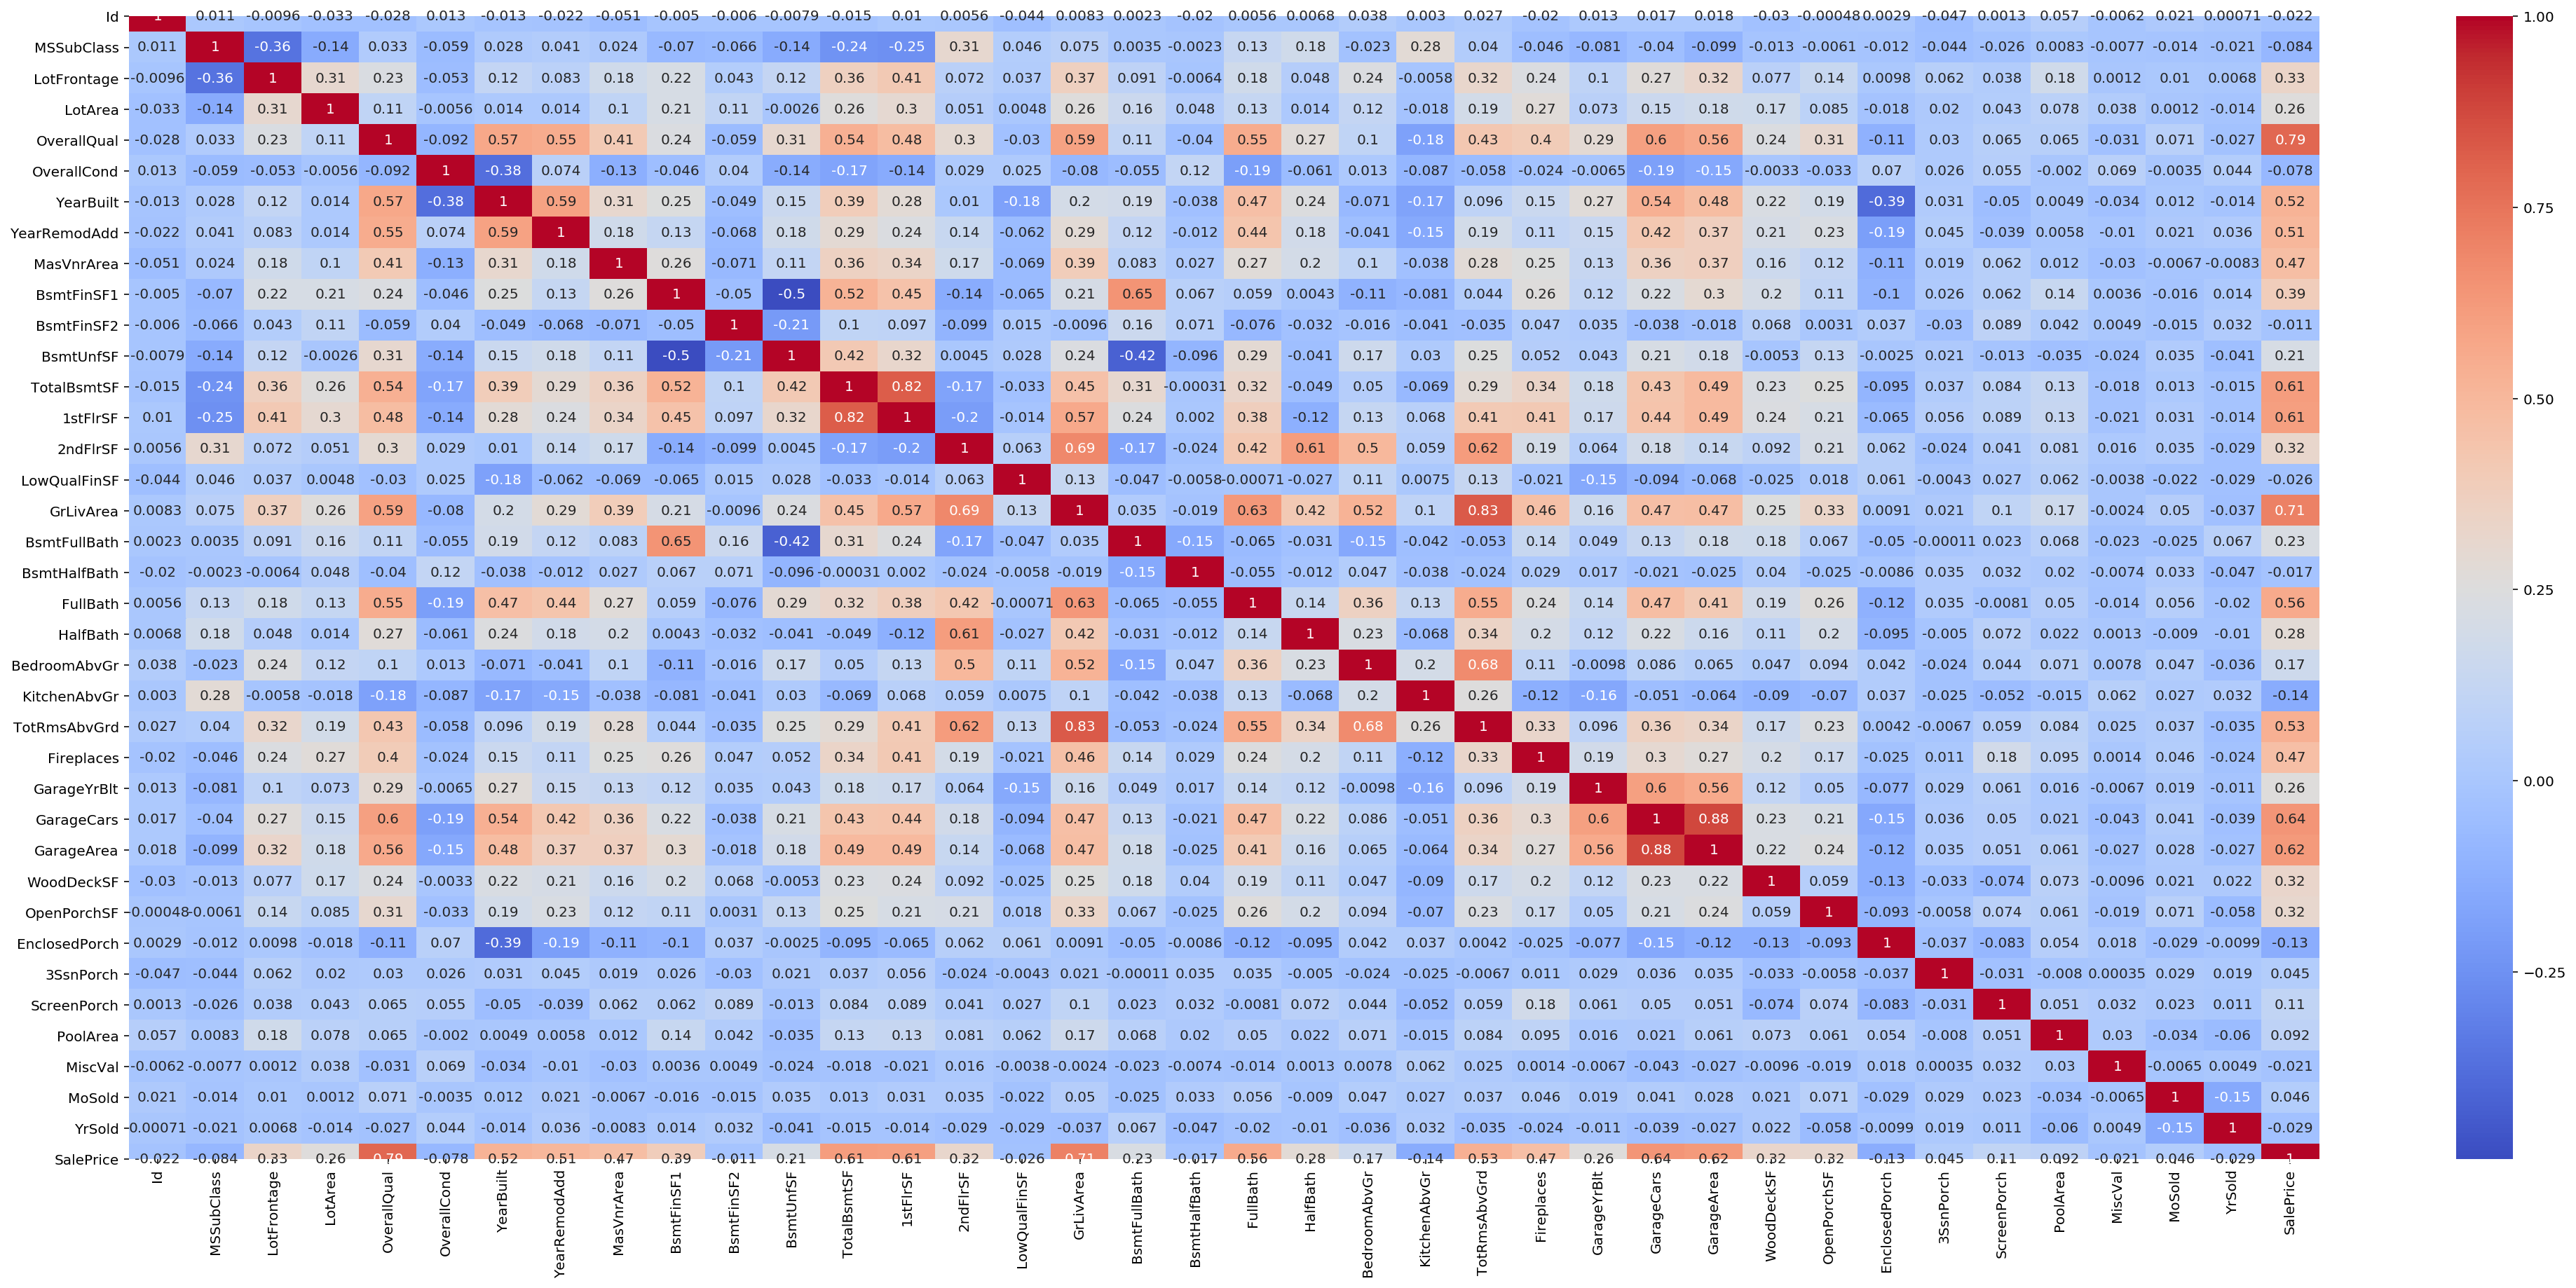

In [16]:
plt.figure(figsize=[35, 15])
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

In [17]:
train.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd'], axis=1, inplace=True)
test1.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd'], axis=1, inplace=True)

In [18]:
train = train[train['GrLivArea'] < 4000]

In [19]:
len_train = train.shape[0]
len_train

1456

In [20]:
house = pd.concat([train, test1], sort=False)

In [21]:
house.shape

(2915, 78)

Tranform info

In [22]:
house['MSSubClass'] = house['MSSubClass'].astype(str)

In [23]:
skew = house.select_dtypes(include=['int', 'float']).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_df = pd.DataFrame({'skew':skew})

In [24]:
skewed_df = skew_df[(skew_df['skew']>0.5) | (skew_df['skew']<-0.5)]

In [25]:
skewed_df.index

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'SalePrice',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF',
       'Fireplaces', 'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond',
       'YearBuilt', 'GarageYrBlt'],
      dtype='object')

In [26]:
train = house[:len_train]
test = house[len_train:]

In [27]:
lam = 0.1
for col in ('MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'SalePrice',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF',
       'Fireplaces', 'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond',
       'YearBuilt', 'GarageYrBlt'):
    train[col] = boxcox1p(train[col],lam)
    test[col] = boxcox1p(test[col], lam)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
train['SalePrice'] = np.log(train['SalePrice'])

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [29]:
house.shape

(2915, 78)

In [30]:
house.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,5.203879,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,3.179462
1,2,20,RL,5.518456,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,3.159767


In [31]:
house = pd.concat([train, test], sort=False)
house = pd.get_dummies(house)

In [32]:
house.shape

(2915, 317)

In [33]:
house.head(2)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,5.203879,14.699651,7,1.962312,11.388965,2003,6.960811,9.272672,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2,5.518456,15.016794,6,2.457309,11.359971,1976,0.000000,9.910321,0.0,...,0,0,0,1,0,0,0,0,1,0


In [34]:
train = house[:len_train]
test = house[len_train:]

In [35]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
x = train.drop('SalePrice', axis=1)
y = train['SalePrice']
test = test.drop('SalePrice', axis=1)

In [37]:
sc = RobustScaler()
x = sc.fit_transform(x)
test = sc.transform(test)

In [38]:
model = Lasso(alpha = 0.001, random_state = 1)

In [39]:
model.fit(x,y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
pred = model.predict(test)
preds=np.exp(pred)

In [41]:
preds

array([22.25344248, 22.93610856, 23.51221272, ..., 23.42812404,
       22.09630407, 24.46639504])

In [42]:
output = pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})

In [43]:
output.head()

,Id,SalePrice
0,1461,22.253442
1,1462,22.936109
2,1463,23.512213
3,1464,23.908827
4,1465,23.751576
